In [1]:
import sys

#######
N_RUNS = 10
import warnings
warnings.filterwarnings("ignore")
#####


# In[2]:


import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))


# In[3]:


from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


# In[4]:


print("Map properties")


# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3


from tqdm import trange,tqdm
import pickle

from itertools import product

poss = list(product([True, False], range(N_RUNS)))


oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb')
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])
unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
funlensedTT = lambda L:np.exp(funlensedTT_log(L))


L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK_log = interp1d(L, np.log(rawKK), kind='linear', bounds_error=False, fill_value=0.)
fKK = lambda L:np.exp(fKK_log(L))


L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT_log = interp1d(L, np.log(F), kind='linear', bounds_error=False, fill_value=0.)
flensedTT = lambda L:np.exp(flensedTT_log(L))


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT_log = interp1d(L, np.log(cTgradT), kind='linear', bounds_error=False, fill_value=0.)
fTgradT = lambda L:np.exp(fTgradT_log(L))



Map properties
../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [2]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
cmb.fCtotal = ftot 

frandomizePhase = lambda z: np.abs(z) * np.exp(1j*np.random.uniform(0., 2.*np.pi))

In [3]:
# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)


In [4]:
def gen_clFourier(fcur, baseMap):
    f = lambda l: np.sqrt(fcur(l))
    clFourier = np.array(list(map(f, baseMap.l.flatten())))
    clFourier = np.nan_to_num(clFourier)
    clFourier = clFourier.reshape(np.shape(baseMap.l))
    return clFourier

In [5]:
print('precomputing Cls')
clFourier_ftot = gen_clFourier(ftot, baseMap)


precomputing Cls


In [6]:
totalCmbFourier = baseMap.genGRF(ftot, clFourier= clFourier_ftot)
dataFourier = np.ones_like(totalCmbFourier)
dataFourier *= clFourier_ftot * np.sqrt((baseMap.sizeX)* (baseMap.sizeY))


TRand = np.array(list(map(frandomizePhase, dataFourier.flatten())))
TRand = TRand.reshape(dataFourier.shape)

In [7]:
sqrtNhat = baseMap.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                        cmb.fCtotal, 
                                                        lMin=lMin, lMax=lMax, 
                                                        dataFourier=TRand)

In [8]:
# number of pixels for the flat map
nX = 600
nY = 600

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMapSmall = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)
print('precomputing Cls')
clFourier_ftot = gen_clFourier(ftot, baseMapSmall)
totalCmbFourier = baseMapSmall.genGRF(ftot, clFourier= clFourier_ftot)
dataFourier = np.ones_like(totalCmbFourier)
dataFourier *= clFourier_ftot * np.sqrt((baseMapSmall.sizeX)* (baseMapSmall.sizeY))


TRandSmall = np.array(list(map(frandomizePhase, dataFourier.flatten())))
TRandSmall = TRandSmall.reshape(dataFourier.shape)

precomputing Cls


In [9]:
sqrtNhatSmall = baseMapSmall.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                        cmb.fCtotal, 
                                                        lMin=lMin, lMax=lMax, 
                                                        dataFourier=TRandSmall)



In [10]:

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMapMedium = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)
print('precomputing Cls')
clFourier_ftot = gen_clFourier(ftot, baseMapMedium)
totalCmbFourier = baseMapMedium.genGRF(ftot, clFourier= clFourier_ftot)
dataFourier = np.ones_like(totalCmbFourier)
dataFourier *= clFourier_ftot * np.sqrt((baseMapMedium.sizeX)* (baseMapMedium.sizeY))


TRandMedium = np.array(list(map(frandomizePhase, dataFourier.flatten())))
TRandMedium = TRandMedium.reshape(dataFourier.shape)

sqrtNhatMedium = baseMapMedium.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                        cmb.fCtotal, 
                                                        lMin=lMin, lMax=lMax, 
                                                        dataFourier=TRandMedium)


precomputing Cls


In [11]:
Nhat = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=51)
NhatSmall = baseMapSmall.powerSpectrum(dataFourier=sqrtNhatSmall, nBins=51)
NhatMedium = baseMapMedium.powerSpectrum(dataFourier=sqrtNhatMedium, nBins=51)

In [12]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 
LBinned, NtheoryBinned = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=51)

print("Gets a theoretical prediction for the noise")
fNqCmb_fftSmall = baseMapSmall.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
NtheorySmall = lambda l: fNqCmb_fftSmall(l) 
LBinnedSmall, NtheoryBinnedSmall = baseMapSmall.binTheoryPowerSpectrum(NtheorySmall, nBins=51)


Gets a theoretical prediction for the noise
computing the reconstruction noise
Gets a theoretical prediction for the noise
computing the reconstruction noise


In [13]:

print("Gets a theoretical prediction for the noise")
fNqCmb_fftMedium = baseMapMedium.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
NtheoryMedium = lambda l: fNqCmb_fftMedium(l) 
LBinnedMedium, NtheoryBinnedMedium = baseMapMedium.binTheoryPowerSpectrum(NtheoryMedium, nBins=51)



Gets a theoretical prediction for the noise
computing the reconstruction noise


In [ ]:

# print("Gets a theoretical prediction for the noise")
# fNqCmb_fftMedium = baseMapMedium.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
# NtheoryMedium = lambda l: fNqCmb_fftMedium(l) 
# LBinnedMedium, NtheoryBinnedMedium = baseMapMedium.binTheoryPowerSpectrum(Ntheory, nBins=51)



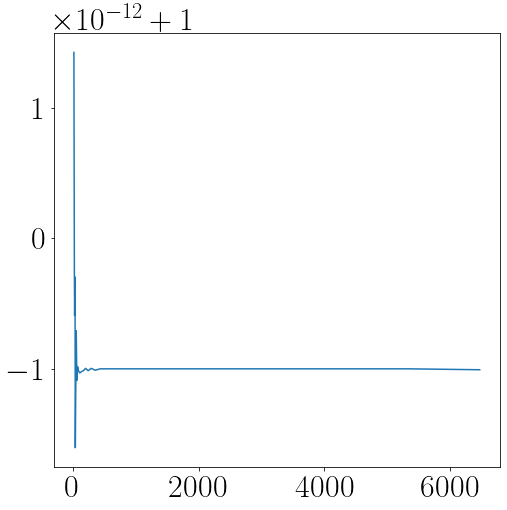

In [15]:
plt.figure(figsize=(8,8))

lnum = np.copy(Nhat[0])

plt.plot(lnum, Ntheory(lnum) / NtheoryMedium(lnum))

In [24]:
np.max(baseMapSmall.l)

7636.753236814713

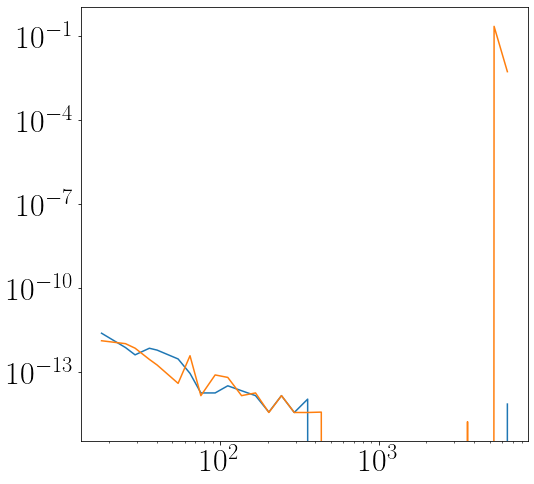

In [31]:
plt.figure(figsize=(8,8))

lnum = np.copy(Nhat[0])

plt.plot(lnum,  np.abs(NtheoryMedium(lnum)/ Ntheory(lnum)-1))
plt.plot(lnum,  np.abs(NtheorySmall(lnum)/ Ntheory(lnum)-1))

plt.yscale('''log''')
plt.xscale('''log''')

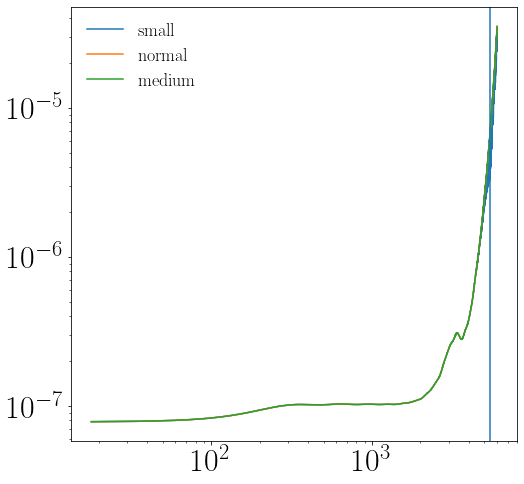

In [26]:
plt.figure(figsize=(8,8))

lnum = np.arange(6000)

# plt.plot(lnum, Ntheory(lnum) / NtheorySmall(lnum))
plt.plot(lnum, NtheorySmall(lnum), label='small')
plt.plot(lnum, Ntheory(lnum), label='normal')
plt.plot(lnum, NtheoryMedium(lnum), label='medium')

plt.yscale('''log''')
plt.xscale('''log''')
plt.axvline(5400)
# plt
plt.legend(frameon=False)

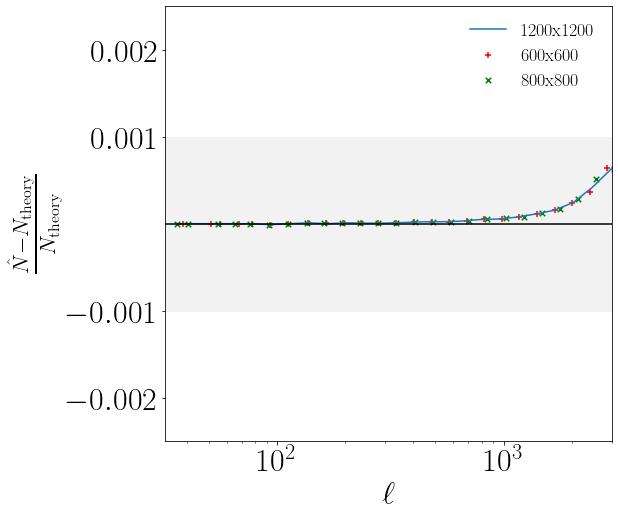

In [14]:
plt.figure(figsize=(8,8))
assert((Nhat[0] == LBinned).all())
assert((NhatSmall[0] == LBinnedSmall).all())
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.95')#, label=r'$<1\%$ Error')

plt.plot(Nhat[0], (Nhat[1]-NtheoryBinned)/NtheoryBinned, label='1200x1200')
# plt.plot(NhatSmall[0], (NhatSmall[1]-NtheoryBinnedSmall)/NtheoryBinnedSmall, label='600x600')
plt.scatter(NhatSmall[0], (NhatSmall[1]-NtheoryBinnedSmall)/NtheoryBinnedSmall, 
            c='r', marker='+',
            s=30, label='600x600')



plt.scatter(NhatMedium[0], (NhatMedium[1]-NtheoryBinnedMedium)/NtheoryBinnedMedium, 
            c='g', marker='x',
            s=30, label='800x800')

plt.xscale('log')



plt.legend(frameon=False)
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{\hat N-N_{\rm theory}}{N_{\rm theory}}$')

# ax.set_yscale('log')
plt.xlim(lMin,2*lMax)
# ax.set_ylim(1.1e-10,.9e-3)


# ax.set_yscale('symlog', linthresh=.5e-2) 

plt.axhline(0, c='k')

plt.ylim(-.25e-2, .25e-2)
plt.xlim(32, 3000)
plt.yticks([-0.001,- 0.002,0.001, 0.002])
plt.legend(frameon=False)
# ax.set_yticks([-1e-1,-1e-2,-1e-3,1e-1,1e-2,1e-3])
plt.savefig('figures/is nhat trand aliasing.pdf')